In [7]:
import platform
import sys

print("Python version:", sys.version)
print("Architecture:", platform.architecture())


Python version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
Architecture: ('64bit', 'WindowsPE')


In [8]:
import numpy as np
import os
from matplotlib import pyplot as plt
from filters.filters import ParticleFilter
from tools.objects import Gaussian
from tools import compare, data_processing, transform, utils
from tools.tools_ahrs import plot
from datasets.data import TUMData
import mrob

In [9]:
dataset_name = "dataset-corridor1_512_16"
x3_path = os.path.join("C:\skoltech\Term 3\Persption\Filters-for-IMU-Attitude-Estimation\src\TUM-VI\imu0\calib_imu1.csv")
mocap_path = os.path.join("C:\skoltech\Term 3\Persption\Filters-for-IMU-Attitude-Estimation\src\TUM-VI\mocap0\calib_imu1.csv")
# take_name = "outdoors1.csv"

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Admin Admin\AppData\Local\Temp\ipykernel_18356\2240713230.py:2: SyntaxWarning: invalid escape sequence '\s'
  x3_path = os.path.join("C:\skoltech\Term 3\Persption\Filters-for-IMU-Attitude-Estimation\src\TUM-VI\imu0\calib_imu1.csv")
C:\Users\Admin Admin\AppData\Local\Temp\ipykernel_18356\2240713230.py:3: SyntaxWarning: invalid escape sequence '\s'
  mocap_path = os.path.join("C:\skoltech\Term 3\Persption\Filters-for-IMU-Attitude-Estimation\src\TUM-VI\mocap0\calib_imu1.csv")


In [10]:
tumdata = TUMData(x3_path, mocap_path)
t_base, data_gyr, data_acc = tumdata.import_imu_data(downsample=False, smoothing=False)
data_mocap_t, data_mocap_q, data_mocap_T = tumdata.import_mocap_data(downsample=False, smoothing=False)

In [11]:
t_base, data_gyr, data_acc, data_acc, data_mocap_q = data_processing.sync_mocap_and_data(data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc)

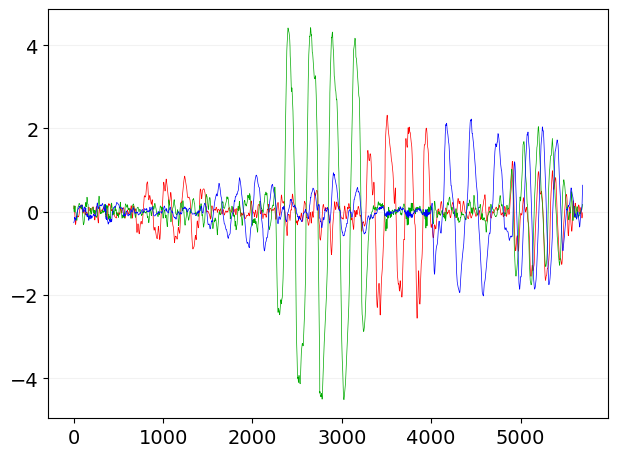

In [12]:
plot(data_gyr)

In [13]:
data_mocap_angvel = transform.quats_to_angvels(data_mocap_t, data_mocap_q)
action_cov = utils.calc_cov(data_gyr[:-1], data_mocap_angvel)
print(action_cov)

[[ 0.19734958 -0.03134995 -0.05541679]
 [-0.03134995  0.0677625   0.03183384]
 [-0.05541679  0.03183384  0.10216226]]


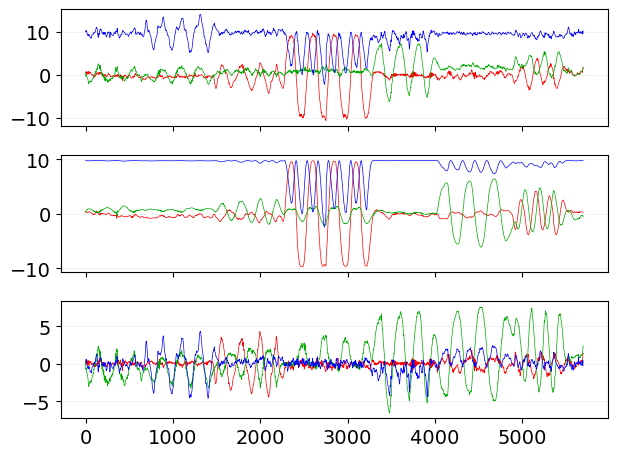

[[ 1.41119922 -0.72033714 -0.03526688]
 [-0.72033714  1.84968802  1.21413011]
 [-0.03526688  1.21413011  2.29894293]]


In [14]:
g = np.array([0, 0, -9.81])
data_mocap_acc = np.array([np.linalg.inv(mrob.quat_to_so3(data_mocap_q[i])) @ g for i in range(len(data_mocap_q))])
start = 0000
end = 2000
measurement_cov = utils.calc_cov(data_acc[start:end], data_mocap_acc[start:end])
plot(data_acc, data_mocap_acc, data_acc - data_mocap_acc)
print(measurement_cov)

# Not so good results with these covs

In [15]:

x3_path_my = os.path.join("data", "X3_simple", "Random_walk_2025-03-06_19-02-36.207_TGW")
# x3_path = "madgwick_filter/recordings/X3_simple/Standing_still_2025-03-06_18-50-19.416_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/Basic_motions_2025-03-06_18-45-09.848_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/Walking_2025-03-06_18-37-32.144_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/Walking_talking_2025-03-06_18-41-53.764_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/Random_walk_2025-03-06_19-02-36.207_TGW"

mocap_path_my = os.path.join("data", "Mocap_simple", "Random_walk_Take 2025-03-06 06.38.58 PM_004.csv")
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Standing_still_Take 2025-03-06 06.38.58 PM_003.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Basic_motions_Take 2025-03-06 06.38.58 PM_002.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Walking_Take 2025-03-06 06.38.58 PM.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Walking_talking_Take 2025-03-06 06.38.58 PM_001.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Random_walk_Take 2025-03-06 06.38.58 PM_004.csv"


In [16]:
import_myrecording = False
if import_myrecording:
    t_base, data_gyr, data_acc, data_magn = data_processing.import_combined_data(os.path.join(x3_path_my, "combined_imu_data_7.csv"))
    t_base = t_base/1000
    data_mocap_t, data_mocap_q = data_processing.import_gamerotvec_data(os.path.join(x3_path_my, "game_rotation_vector_12.csv"))
    data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc= data_processing.trim_to_min_length(data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc)

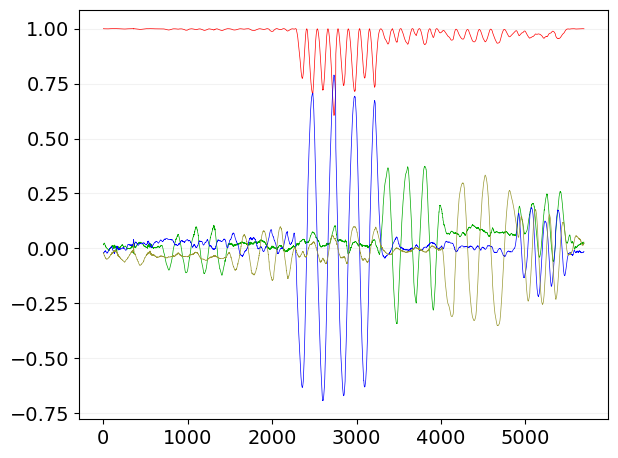

In [17]:
plot(data_mocap_q)

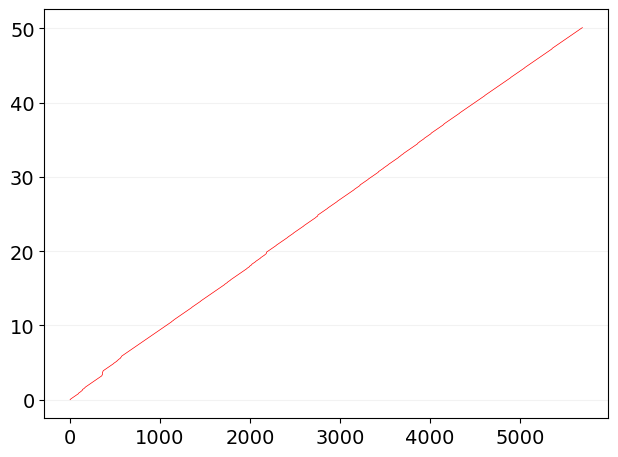

In [18]:
plot(data_mocap_t - data_mocap_t[0])

In [19]:
mean_prior = np.array([0, 0, 0.])
Sigma_prior = 1e1 * np.eye(3, 3)
M = 1e-4 * np.eye(3, 3)                                 # rad/s         ~(0.00122 ** 2) from sensors.csv
Q = 1e-3 * np.eye(3, 3) * (9.81 ** 2)                   # rads * g^2    ~(0.00239 ** 2) from sensors.csv
# worse results with covs from sensors or from np.cov
#M = np.diag(np.diag(action_cov))
#Q = np.diag(np.diag(measurement_cov))
initial_state = Gaussian(mean_prior, Sigma_prior)
g = np.array([0, 0, -9.81])
u_bias = np.array([0, 0, 0.000])
pf = ParticleFilter(initial_state, M, Q, g, u_bias)
u = data_gyr
N = len(data_gyr)
dts = np.empty(N)
freq_sm = 200
dts[0] = 1/freq_sm
dts[1:] = np.array([t_base[i+1] - t_base[i] for i in range(N-1)])
preds = np.empty((N, 3))
s_preds = np.empty((N, 3, 3))
ups = np.empty((N, 3))
s_ups = np.empty((N, 3, 3))
Ks = np.empty((N, 3, 3))
IVs = np.empty((N, 3))
gt = transform.quats_to_rpy(data_mocap_q)

In [20]:
for i in range(N):
    pf.predict(u[i], dts[i])
    pf.update(data_acc[i])
    preds[i, :] = pf.mu_bar
    s_preds[i] = pf.Sigma_bar
    ups[i] = pf.mu
    s_ups[i] = pf.Sigma

In [21]:
print(pf.Sigma_bar)

[[11.87288915 -0.67229819  0.01500736]
 [-0.67229819 10.0989073   1.57766216]
 [ 0.01500736  1.57766216 11.88812835]]


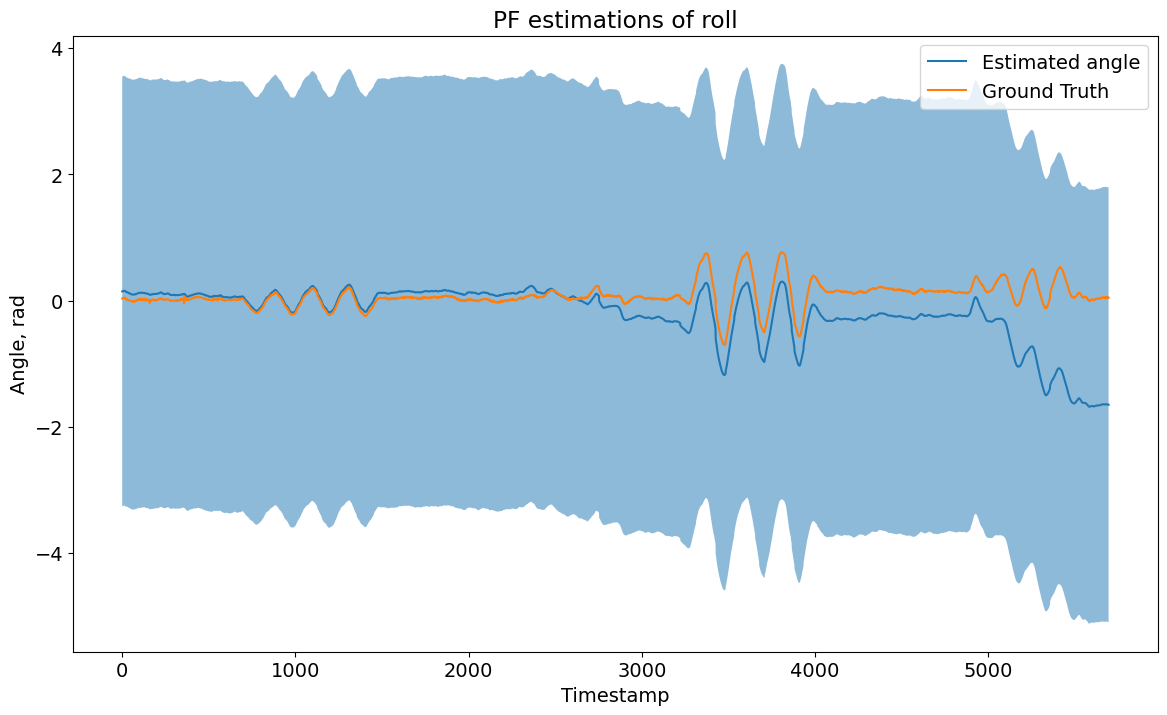

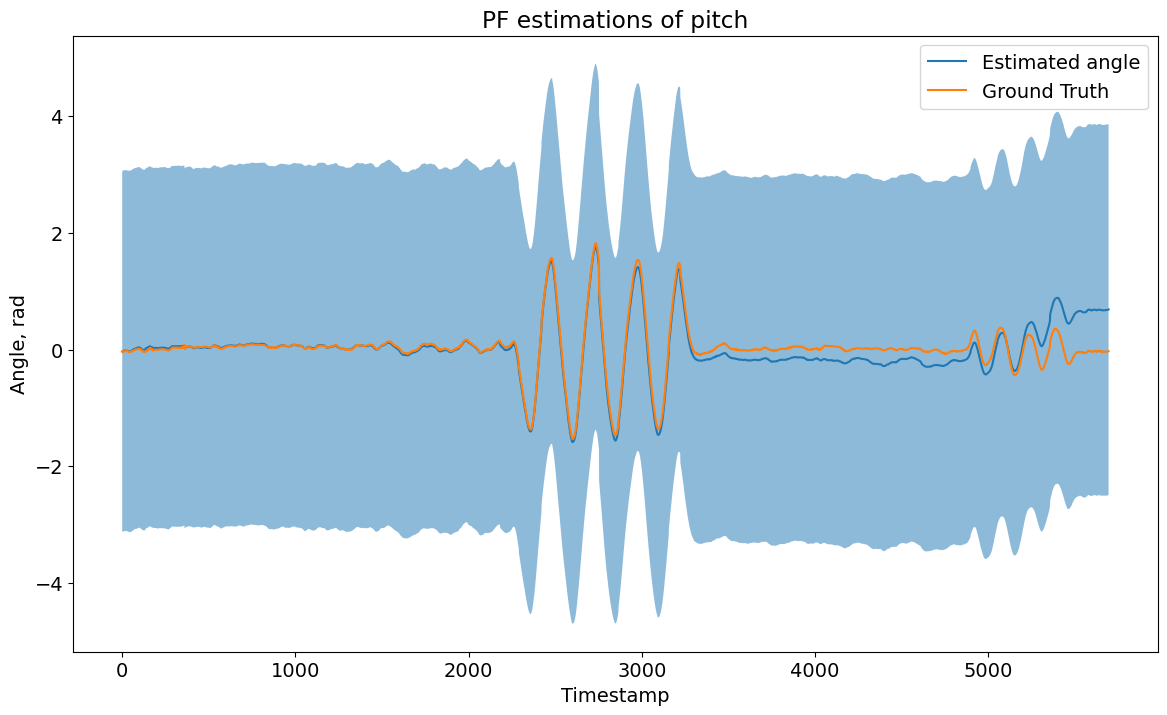

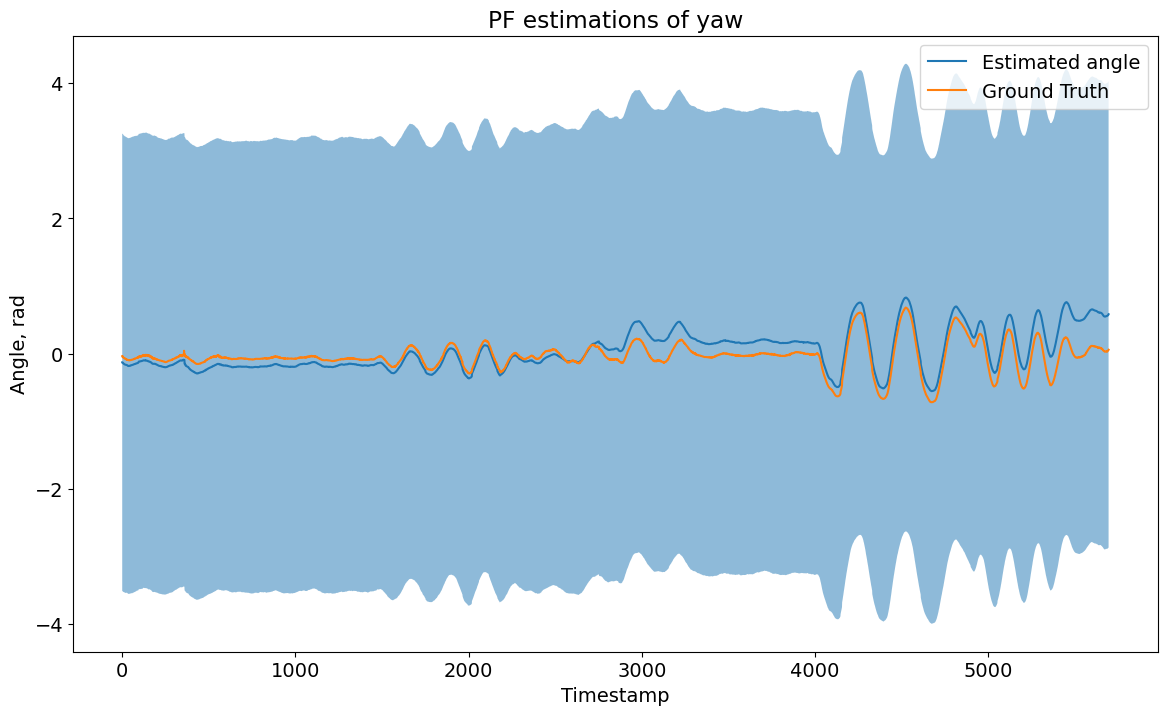

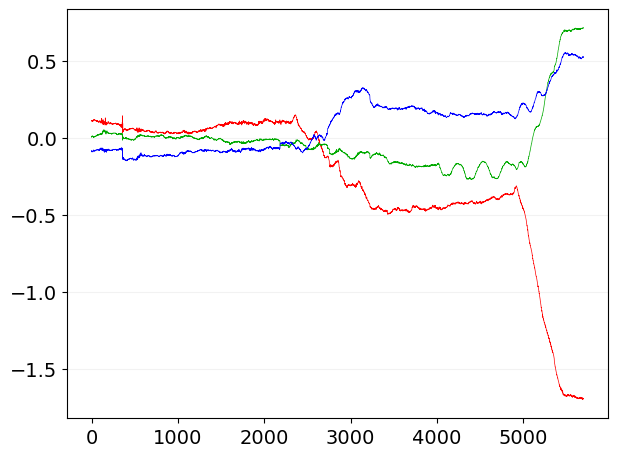

In [22]:
compare.plot_covs(ups, s_ups, 0, gt)
compare.plot_covs(ups, s_ups, 1, gt)
compare.plot_covs(ups, s_ups, 2, gt)
plot(ups - gt)

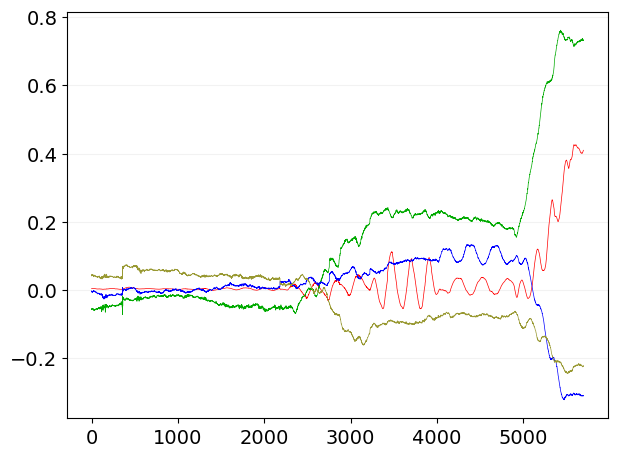

In [23]:
q1 = transform.rpy_to_quats(gt)
q2 = transform.rpy_to_quats(ups)
plot(q1 - q2)

Mean distance between smartphone and mocap attitude estimations:
0.4191912398525938
Distance between smartphone and mocap attitude estimations:


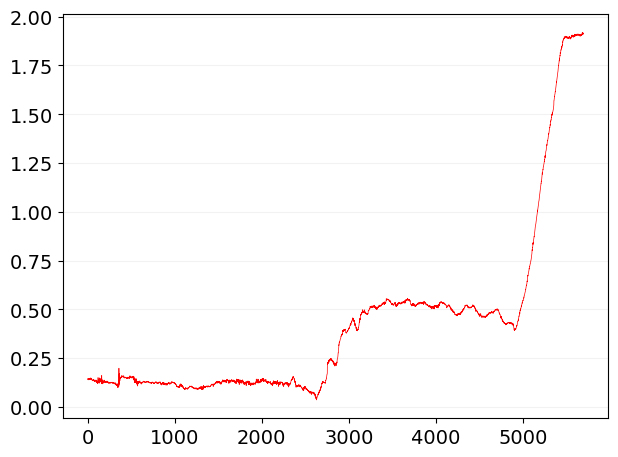

Last distance between smartphone and mocap attitude estimations:
1.9128009720182406
Norm of quaternions - shall be = 1
[1. 1. 1. ... 1. 1. 1.]


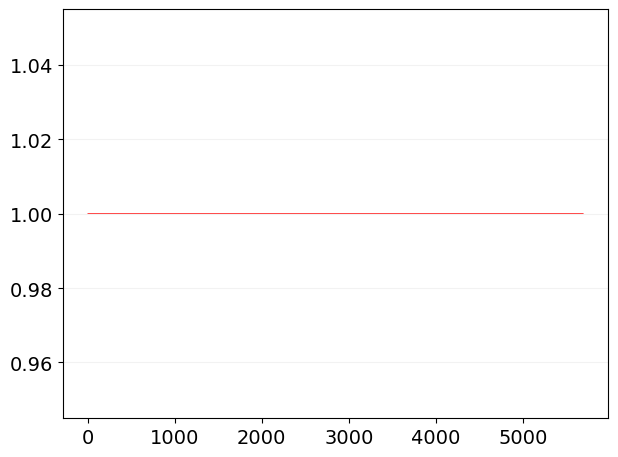

G vectors in smartphone and (mocap-observed-smartphone) reference frames


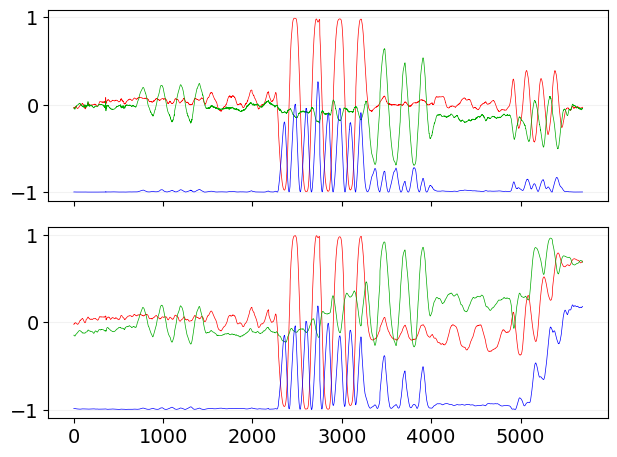

Difference between G vectors in smartphone and (mocap-observed-smartphone) reference frames


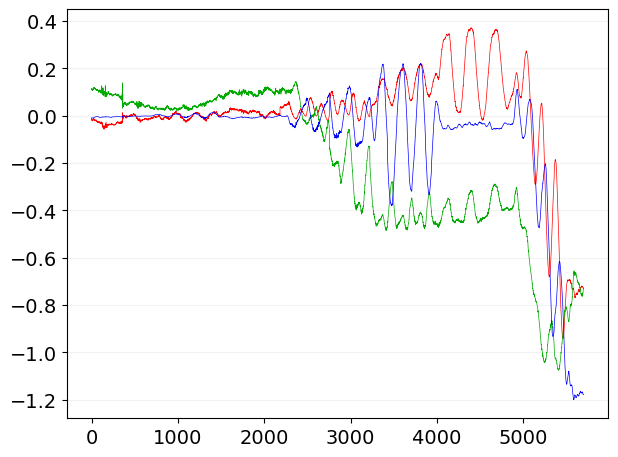

Mean distance between smartphone and mocap vector g estimations:
0.3692341734722539
Distance between smartphone and mocap vector g estimations:


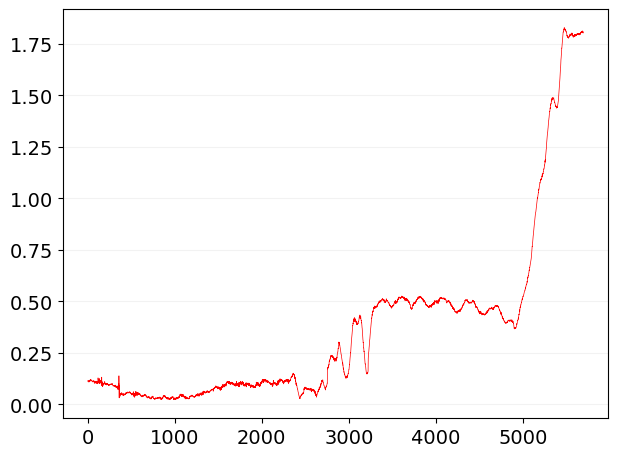

Last distance between smartphone and mocap vector g estimations:
1.8023533274625183
Mean Relative Pose Error
0.0050289159706972415
Relative Pose Error


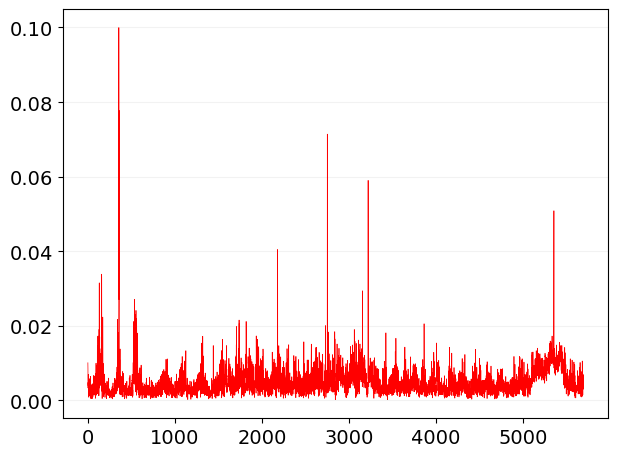

Last RPE between smartphone and mocap attitude estimations:
0.005005974847044832
Mean Relative Pose Error of vector g
0.004089238851222666
Relative Pose Error of vector g


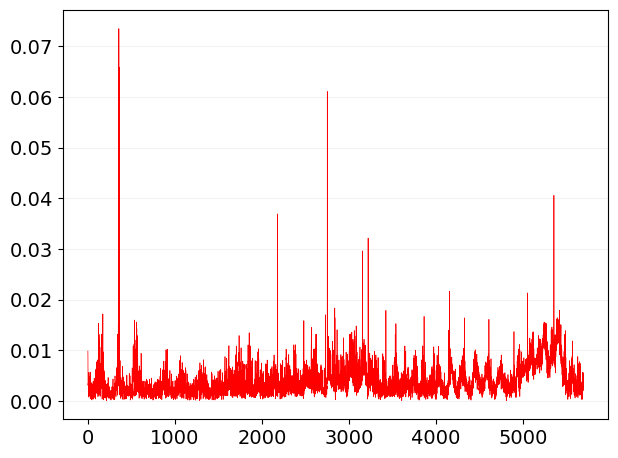

Last RPE between smartphone and mocap vector g estimations:
0.005388924072808557


(array([0.1450184 , 0.13857094, 0.14029562, ..., 1.91631987, 1.91016083,
        1.91280097]),
 array([0.11491465, 0.11273271, 0.11072864, ..., 1.80747334, 1.80119418,
        1.80235333]),
 array([0.01006358, 0.00846716, 0.00331863, ..., 0.00296372, 0.00663134,
        0.00500597]),
 array([0.00987213, 0.00821366, 0.00327832, ..., 0.0020206 , 0.00455675,
        0.00538892]))

In [24]:
compare.errors_estimation(q1, q2)